In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.decomposition import PCA
import scipy.optimize

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path1p, "lib")
pwd_mat = os.path.join(os.path.join(path2p, "data/"), "sim_ds_mat")
pwd_h5 = os.path.join(os.path.join(path2p, "data/"), "sim_ds_h5")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_yaro_lib import read_mat
from matlab.matlab_lib import loadmat
from corr_lib import sprMat
from qt_wrapper import gui_fpath

Appended library directory /media/aleksejs/DataHDD/work/codes/theoretical-models/experimental-bridge/nest-mesoscopic-metric-test/codes/lib


## 0. Loading data

In [2]:
# Read LVM file from command line
pwd = '/mnt/hifo_scratch1/Yaro/data_for_TE/'
data_path = gui_fpath("Select data directory", pwd)
data, behaviour = read_mat(data_path)

# Get parameters
nTrials, nTimes, nChannels = data.shape
print("Loaded neuronal data with (nTrials, nTimes, nChannels)=", data.shape)

pd.DataFrame(behaviour['trials'])

Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_7/mvg_7_2018_11_15_a
Loaded neuronal data with (nTrials, nTimes, nChannels)= (470, 201, 48)


,auto_reward,decision,decision_time,end_time,id,inhibition,no,puff,report,reward_time,stimulus,stimulus_time,time_stamp
0,1.0,No Response,6231.7,8491.9,1,none,1,[],report,NaN,Texture 1 P100,3126.4,12:20:46.2216
1,1.0,No Response,5997.6,8254.8,2,none,2,[],report,NaN,Texture 1 P100,3065.3,12:21:00.8351
2,1.0,No Response,6002.6,8259.9,3,none,3,[],report,NaN,Texture 1 P100,3066.3,12:21:15.2165
3,NaN,Go,5931.6,8250.8,4,none,4,[],report,5929.6,Texture 1 P100,3066.3,12:21:29.5980
4,NaN,Go,6983.7,9300.9,5,none,5,[],report,6980.7,Texture 1 P100,3069.3,12:21:43.9694
5,NaN,Go,6190.6,8495.8,6,none,6,[],report,6187.6,Texture 1 P100,3066.3,12:21:59.3910
6,NaN,Inappropriate Response,5929.6,10145.0,7,none,7,[],report,NaN,Texture 3 P1200,3067.3,12:22:14.0124
7,NaN,Inappropriate Response,5994.6,10210.1,8,none,8,[],report,NaN,Texture 3 P1200,3067.4,12:22:30.2850
8,NaN,No Response,7499.7,9759.0,9,none,9,[],report,NaN,Texture 1 P100,3066.3,12:22:46.6197
9,NaN,Go,5930.6,8247.8,10,none,10,[],report,5927.6,Texture 1 P100,3065.3,12:23:02.5013


# 1. Autoregression

What to include into model:
1. Autoregressive Dynamics
$$\vec{x}(t+1) = A\vec{x}(t)$$
2. Neural noise, to model input from external sources
$$\vec{x}(t+1) = A\vec{x}(t) + \nu, \;\;\;\;\; \nu \sim \mathcal{N}(\vec{\mu}, \Sigma)$$
3. Input and input-coupling
$$ \vec{x}(t+1) = A\vec{x}(t) + B\vec{u}(t) + C \vec{x}(t) \vec{u}(t) + \nu$$
4. Observable convolution
$$
\begin{eqnarray}
  \tau \dot{y} &=& -y + x \\
  \vec{y}(t+1) &\approx& \alpha \vec{x}(t) + (1 - \alpha) \vec{y}(t), \;\;\;\;\; \alpha = \frac{\Delta t}{\tau}
\end{eqnarray}$$

**TODO**:
* See what tools for autoregressors exist
* Read literature on DCM, understand how it works, how it is different from autoregressor
* For observable autoregressor, is it not equivalent to simply deconvolving data and then using basic deconvolved?
   $$x(t) = y(t) + \frac{y(t+1) - y(t)}{\alpha}$$
   * Ask Yaro if he thinks this makes sense
   * Look for most optimal deconvolution tool for this process

In [3]:
def unpack(Aarr):
    return Aarr.reshape(nChannels, nChannels)

def model(Data, A):   # Future time step from prev. one
    return Data.dot(A.T)

# def L(Aarr):
#     Amat = unpack(Aarr)
#     data_guess = model(data, Amat)
#     residue = np.linalg.norm(data[:, 1:, :] - data_guess[:, :-1, :])
#     return residue

d_0 = data[:, :-1, :].transpose(2, 0, 1).reshape(nChannels, (nTimes-1)*nTrials)
d_1 = data[:, 1:, :].transpose(2, 0, 1).reshape(nChannels, (nTimes-1)*nTrials)
len_d = d_0.shape[1]

D1 = np.linalg.norm(d_1)**2
D10  = np.einsum('ij, kj', d_1, d_0)
D00 = np.einsum('kj, lj', d_0, d_0)

C_REG = 5.0

def reg(Amat):
    return C_REG*np.sum(np.abs(Amat))

def L2_fast(Aarr):
    Amat = unpack(Aarr)
    B = -2*np.einsum('ij, ij', Amat, D10)
    C = np.einsum('ik,il,kl', Amat, Amat, D00)
    return D1 + B + C + reg(Amat)

def L2_jac(Aarr):
    Amat = unpack(Aarr)
    Jac2D = -2 * (D10 - Amat.dot(D00)) + C_REG*np.sign(Amat)
    return Jac2D.flatten()

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/scipy/optimize/_minimize.py:430: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)


False
Desired error not necessarily achieved due to precision loss.
True
Optimization terminated successfully.
5.541875321865996 compared to 24.23380658967428


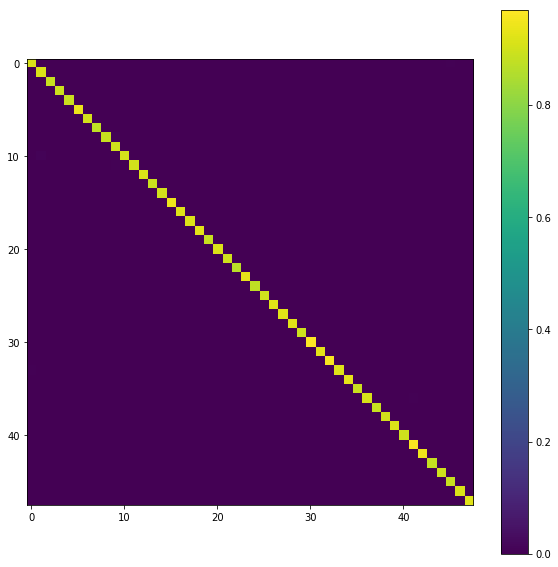

CPU times: user 1min 28s, sys: 764 ms, total: 1min 29s
Wall time: 1min 28s


In [23]:
%%time
# Example 1:
A0arr = np.diag(np.ones(nChannels)).flatten() + np.random.uniform(0, 0.1, nChannels**2)

bounds = [(0, 10) for i in range(nChannels**2)]
min_obj = scipy.optimize.minimize(L2_fast, A0arr, jac=L2_jac, bounds=bounds, method='CG')#, method='SLSQP')
print(min_obj.success)
print(min_obj.message)
# min_obj = scipy.optimize.minimize(L2_fast, min_obj.x, jac=L2_jac, bounds=bounds, method='L-BFGS-B')
# print(min_obj.success)
# print(min_obj.message)
min_obj = scipy.optimize.minimize(L2_fast, min_obj.x, jac=L2_jac, bounds=bounds, method='SLSQP')
print(min_obj.success)
print(min_obj.message)

A = unpack(min_obj.x)
A[A < 1.0e-10] = 0

# Compute fitness
L2_without_reg = np.sqrt(min_obj.fun - reg(A))
print(L2_without_reg, "compared to", np.linalg.norm(data[:, 1:, :]))

plt.figure(figsize=(10,10))
plt.imshow(unpack(min_obj.x))
plt.colorbar()
plt.show()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,9.147806e-01,7.665940e-06,6.805560e-10,3.385438e-10,0.000000e+00,2.954557e-10,3.352975e-10,0.000000e+00,0.000000e+00,9.420648e-10,...,1.715174e-10,0.000000e+00,3.263521e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.960742e-03,8.378595e-04,3.534409e-10
1,0.000000e+00,9.148983e-01,0.000000e+00,6.202958e-04,1.013289e-05,0.000000e+00,0.000000e+00,6.595154e-10,4.267485e-04,9.845091e-07,...,2.532943e-10,0.000000e+00,0.000000e+00,0.000000e+00,1.912947e-07,0.000000e+00,0.000000e+00,0.000000e+00,1.100137e-09,4.559698e-10
2,0.000000e+00,0.000000e+00,8.855677e-01,0.000000e+00,3.950629e-10,1.695350e-10,0.000000e+00,0.000000e+00,2.745151e-10,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,2.933244e-10,4.806432e-10,0.000000e+00,0.000000e+00,0.000000e+00,1.611172e-04,0.000000e+00
3,5.483538e-10,1.187848e-07,0.000000e+00,8.932841e-01,0.000000e+00,3.287266e-05,0.000000e+00,0.000000e+00,7.481839e-10,4.714375e-09,...,1.776886e-10,1.583060e-10,1.797290e-10,2.354290e-10,0.000000e+00,0.000000e+00,0.000000e+00,4.043446e-10,0.000000e+00,3.245980e-10
4,9.365366e-10,2.398047e-03,2.958286e-10,0.000000e+00,8.925069e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.836381e-10,7.396296e-07,...,2.327741e-10,2.714661e-10,0.000000e+00,4.202574e-10,0.000000e+00,6.580090e-10,0.000000e+00,2.938349e-06,0.000000e+00,0.000000e+00
5,0.000000e+00,0.000000e+00,0.000000e+00,3.556579e-10,4.827743e-10,9.407409e-01,1.960317e-10,0.000000e+00,3.142334e-10,8.844093e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.656740e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.984270e-10
6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.048528e-01,0.000000e+00,4.998627e-10,1.426931e-05,...,0.000000e+00,0.000000e+00,0.000000e+00,2.128975e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.396481e-10,0.000000e+00
7,0.000000e+00,0.000000e+00,2.633909e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.761638e-01,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.989639e-10,0.000000e+00,0.000000e+00,3.904063e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,1.519175e-06,3.940839e-05,0.000000e+00,7.453611e-10,1.294771e-03,0.000000e+00,4.838831e-10,4.774135e-10,8.888866e-01,8.467819e-03,...,0.000000e+00,0.000000e+00,1.742973e-10,3.157405e-10,4.192563e-10,0.000000e+00,0.000000e+00,4.926291e-10,9.677811e-06,3.409158e-10
9,9.091049e-07,2.096287e-03,0.000000e+00,0.000000e+00,2.652081e-07,9.762207e-06,0.000000e+00,7.971210e-10,1.267161e-03,8.986065e-01,...,0.000000e+00,2.342248e-10,0.000000e+00,0.000000e+00,0.000000e+00,5.661026e-07,0.000000e+00,0.000000e+00,1.569959e-04,5.493186e-04


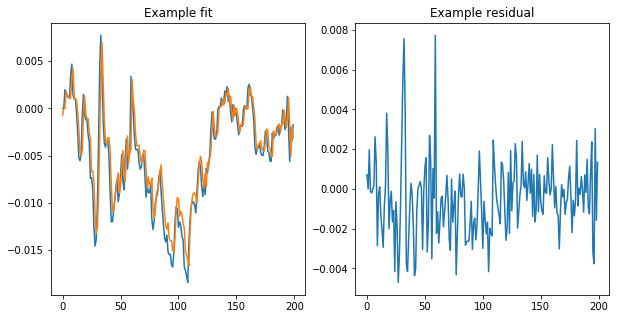

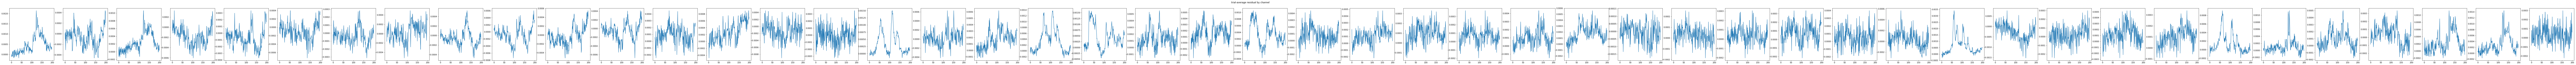

In [24]:
display(pd.DataFrame(A))

Data_model = model(data[:, :-1, :], A)
Residual = data[:, 1:, :] - Data_model

N_CH = 6
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].set_title("Example fit")
ax[1].set_title("Example residual")
ax[0].plot(data[0, 1:, N_CH])
ax[0].plot(Data_model[0, :, N_CH])
ax[1].plot(Residual[0, :, N_CH])
plt.show()

fig, ax = plt.subplots(ncols=nChannels, figsize=(5*nChannels, 5))
fig.suptitle("trial-average residual by channel")
for i in range(nChannels):
    ax[i].plot(np.average(Residual[:, :, i], axis=0))
plt.show()